# Отток клиентов

[Данные](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
#импортируем основные библиотеки для работы
import pandas as pd
import numpy as np

#для построения визуализации
import matplotlib.pyplot as plt
import warnings

In [2]:
#--------------------используемые метрики--------------------------------------------
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, \
                            precision_score, f1_score, roc_curve, roc_auc_score

# -------------------используемые алгоритмы------------------------------------------
#дерево решений
from sklearn.tree import DecisionTreeClassifier
#случайный лес
from sklearn.ensemble import RandomForestClassifier
#логистическая регрессия
from sklearn.linear_model import LogisticRegression

#--------------------вспомогательные функции------------------------------------------
#для разбиения выборок
from sklearn.model_selection import train_test_split
#для прямого кодирования
from sklearn.preprocessing import OrdinalEncoder
#для масштабирования
from sklearn.preprocessing import StandardScaler
#для перемешивания объектов
from sklearn.utils import shuffle

# 1. Подготовка данных

### 1.1. Чтение данных

In [4]:
data = pd.read_csv('/datasets/Churn.csv')
display(data.head())
display(data.tail())
display(data.sample(5))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3811,3812,15589428,Tomlinson,756,France,Female,42,9.0,0.00,2,1,0,35673.42,0
7603,7604,15712483,Chidi,608,Spain,Female,28,4.0,0.00,2,1,0,10899.63,1
729,730,15612525,Preston,499,France,Female,57,1.0,0.00,1,0,0,131372.38,1
4927,4928,15803456,Yen,641,France,Female,40,9.0,0.00,1,0,0,151648.66,1
4561,4562,15638028,Ifeanyichukwu,562,Germany,Male,31,4.0,127237.25,2,0,1,143317.42,0


### 1.2. Замена названий столбцов

In [5]:
#преобразуем названия столбцов к нижнему регистру и переименуем некоторые столбцы
data.columns = data.columns.str.lower()
print(data.columns, '\n')
columns = ['row_number', 'id', 'surname', 'credit_score', 'country',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'is_card',
       'is_active', 'salary', 'exited']

data.columns = columns
print(data.columns)

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object') 

Index(['row_number', 'id', 'surname', 'credit_score', 'country', 'gender',
       'age', 'tenure', 'balance', 'num_of_products', 'is_card', 'is_active',
       'salary', 'exited'],
      dtype='object')


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
row_number         10000 non-null int64
id                 10000 non-null int64
surname            10000 non-null object
credit_score       10000 non-null int64
country            10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             9091 non-null float64
balance            10000 non-null float64
num_of_products    10000 non-null int64
is_card            10000 non-null int64
is_active          10000 non-null int64
salary             10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### 1.3. Описание данных

#1. Каждый объект в наборе данных — это информация о поведении одного клиента банка. В столбце *tenure*  имеются пропуски. Всего в таблице 10 тыс. объектов. Каждый объект характеризуется 14-ю признакими.   

***Целевой признак***  
 **exited** - факт ухода клиента (int64). 

### 1.4. Удаление ненужных столбцов

In [7]:
data['id'].unique().shape

(10000,)

#2. В изначальных данных у нас присутствует избыточная информация для обучения: **row_number** (скорее всего данный столбец является следствием выгрузки данных), **id** (особой смысловой нагрузки на прогноз не оказывает) и **surname** (вряд ли от фамилии зависит уход клиента из банка). Поэтому можем удалить данные колонки из датасета.

In [8]:
data = data.drop(['row_number', 'id', 'surname'], axis=1)
data.head()

,credit_score,country,gender,age,tenure,balance,num_of_products,is_card,is_active,salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### 1.5. Обработка пропусков

#3. В столбце **tenure** присутствуют пропуски.

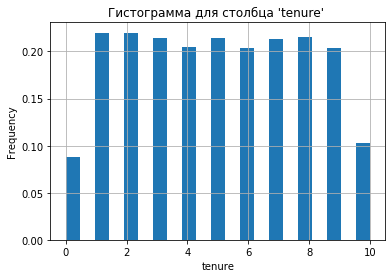

Процент пропусков в "tenure": 9.09%


In [9]:
ax = data['tenure'].plot(kind='hist', grid=True, bins=21, density=True)
ax.set_xlabel('tenure')
ax.set_title('''Гистограмма для столбца 'tenure' ''')
plt.show()
print('Процент пропусков в "tenure": {:.2%}'.format(len(data.query('tenure != tenure')['tenure'])/len(data)))

#4. Получается, что мы имеем некоторое распределение по данному признаку. Заменить пропуск 0, было бы не совсем правильно, так как мы искусственно увеличили бы значимость признака tenure=0. Предлагаю все пропуски пропорционально заменить частотами из гистограммы, т.е. на каждое значение от 1 до 9 отдать по 10% пропусков, а на 0 и 10 по 5% соответственно. Реализуем это и проверим.

In [10]:
#зафиксируем статистические показатели перед изменением
data['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

In [11]:
#всего пропусков
data.query('tenure != tenure')['tenure'].shape

(909,)

In [12]:
#имеем 909 пропусков. 
#Будем случайно вытаскивать из датасета строки с пропусками по 91 штук 9 раз и приравнивать значению от 1.0 до 9.0
for num in np.arange(0.0, 11.0, 1.0):
    
    if num == 0.0 or num == 10.0:
        #выберим случайно 45 индексов у строк с пропусками для последующего изменения
        ind = data.query('tenure != tenure').sample(45).index
    else:
        #выберим случайно 91 индексов у строк с пропусками для последующего изменения
        ind = data.query('tenure != tenure').sample(91).index
    
    #пробегаем по индексам и делаем замену
    for i in ind:
        data.loc[i, 'tenure'] = num

    print(num, '\t', end='')
    print('Кол-во пропусков после замены: ',data.query('tenure != tenure')['tenure'].shape[0])


0.0 	Кол-во пропусков после замены:  864
1.0 	Кол-во пропусков после замены:  773
2.0 	Кол-во пропусков после замены:  682
3.0 	Кол-во пропусков после замены:  591
4.0 	Кол-во пропусков после замены:  500
5.0 	Кол-во пропусков после замены:  409
6.0 	Кол-во пропусков после замены:  318
7.0 	Кол-во пропусков после замены:  227
8.0 	Кол-во пропусков после замены:  136
9.0 	Кол-во пропусков после замены:  45
10.0 	Кол-во пропусков после замены:  0


count    10000.000000
mean         4.997900
std          2.896331
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: tenure, dtype: float64

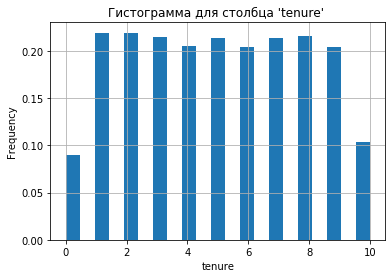

In [13]:
#статистические показатели после заполнения пропусков и гистограмма
display(data['tenure'].describe())

ax = data['tenure'].plot(kind='hist', grid=True, bins=21, density=True)
ax.set_xlabel('tenure')
ax.set_title('''Гистограмма для столбца 'tenure' ''')
plt.show()

#5. Среднее и среднеквадратическое отклонение слегка изменились в 3 и 4-ом знаке после запятой, гистограмма распределения признака осталась практически такой же.

In [14]:
#убедимся, что больше пропусков нет
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
credit_score       10000 non-null int64
country            10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null float64
balance            10000 non-null float64
num_of_products    10000 non-null int64
is_card            10000 non-null int64
is_active          10000 non-null int64
salary             10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


### 1.6. Подготовка категориальных признаков (с численными признаками  разберемся в следующем разделе)

#6. Мы имеем следующие категориальные признаки, требующие подготовки: **gender**, **country**, **tenure**, **num_of_products**. Разберемся с каждым в отдельности.  

Рассмотрим приизнак **gender** - пол, который имеет тип данных object. Произведем здесь порядковое кодирование.

In [15]:
data['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [16]:
data.tail()

,credit_score,country,gender,age,tenure,balance,num_of_products,is_card,is_active,salary,exited
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,792,France,Female,28,6.0,130142.79,1,1,0,38190.78,0


In [17]:
encoder = OrdinalEncoder()

data['gender'] = pd.DataFrame(encoder.fit_transform(data[['gender']]), index=data.index)
data.tail()

,credit_score,country,gender,age,tenure,balance,num_of_products,is_card,is_active,salary,exited
9995,771,France,1.0,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,1.0,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,0.0,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,1.0,42,3.0,75075.31,2,1,0,92888.52,1
9999,792,France,0.0,28,6.0,130142.79,1,1,0,38190.78,0


#7. Остальные категориальные признаки (**country**, **tenure**, **num_of_products**) закодируем, используя прямое кодирование

In [18]:
display(data['country'].value_counts(), data['tenure'].value_counts(), data['num_of_products'].value_counts())
data.shape

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

1.0     1043
2.0     1041
8.0     1024
3.0     1019
5.0     1018
7.0     1016
4.0      976
9.0      973
6.0      972
10.0     491
0.0      427
Name: tenure, dtype: int64

1    5084
2    4590
3     266
4      60
Name: num_of_products, dtype: int64

(10000, 11)

In [19]:
data_ohe = pd.get_dummies(data, columns = ['country', 'tenure', 'num_of_products'], drop_first=True)

In [20]:
display(data_ohe.tail())
data_ohe.shape

,credit_score,gender,age,balance,is_card,is_active,salary,exited,country_Germany,country_Spain,...,tenure_4.0,tenure_5.0,tenure_6.0,tenure_7.0,tenure_8.0,tenure_9.0,tenure_10.0,num_of_products_2,num_of_products_3,num_of_products_4
9995,771,1.0,39,0.00,1,0,96270.64,0,0,0,...,0,1,0,0,0,0,0,1,0,0
9996,516,1.0,35,57369.61,1,1,101699.77,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9997,709,0.0,36,0.00,0,1,42085.58,1,0,0,...,0,0,0,1,0,0,0,0,0,0
9998,772,1.0,42,75075.31,1,0,92888.52,1,1,0,...,0,0,0,0,0,0,0,1,0,0
9999,792,0.0,28,130142.79,1,0,38190.78,0,0,0,...,0,0,1,0,0,0,0,0,0,0


(10000, 23)

### 1.7. Дисбаланс классов

In [21]:
temp = len(data.query('exited == 1'))/len(data)
print('Количество данных об ушедших клиентах в датасете равно {:.2%}'.format(temp))
print('Количество данных действующих клиентов в датасете равно {:.2%}'.format(1-temp))

Количество данных об ушедших клиентах в датасете равно 20.37%
Количество данных действующих клиентов в датасете равно 79.63%


## Вывод

Пропуски в данных в колонке *tenure*  были обработаны. Категориальные признаки подготовлены к исследованию.  Стоит отметить, что объектов с целевым признаком exited равным 0 больше (~80%), т.е. мы будем решать задачу несбалансированной классификации. Причем с точки зрения бизнесабудет важен положительный класс, т.е. мы точно хотим прогнозировать уход клиента из банка.

P.S. Численные признаки будут обработаны после разбиения датасета на выборки в следующем разделе, если понадобиться, то преобразование типов данных будет там же.

# 2. Исследование задачи

### 2.1 Разбиваем датасет на обучающую, валидационную и тестовую выборки.

#8. Разобьем данные на обучающая, валидационную и тестовую выборки в соотношении **3:1:1**

In [22]:
train, tmp = train_test_split(data_ohe, test_size=0.4, random_state=100)
valid, test = train_test_split(tmp, test_size=0.5, random_state=100)
train_valid = pd.concat([train, valid])
#проверим процентное разбиение выборок
print('Обучающая выборка - {:.0%}\nВалидационная выборка - {:.0%}\nТестовая выборка - {:.0%}\nОбучающая+Валидационная  - {:.0%}'.format(
    len(train)/len(data), len(valid)/len(data), len(test)/len(data), len(train_valid)/len(data)))

Обучающая выборка - 60%
Валидационная выборка - 20%
Тестовая выборка - 20%
Обучающая+Валидационная  - 80%


In [23]:
#функция, выводящая процентное соотношение пользователей разных тарифов в выборке
def print_client_ratio(df, Name_dataframe=''):
    try:
        temp = len(df.query('exited	 == 1'))/len(df)
        print(Name_dataframe)
        print('Ушедшие клиенты: {:.2%}'.format(temp))
        print('Оставшиеся клиенты: {:.2%}\n'.format(1-temp))
    except:
        print('Error in print_client_ratio!!!')
        
print_client_ratio(data, 'В целом наборе данных')

В целом наборе данных
Ушедшие клиенты: 20.37%
Оставшиеся клиенты: 79.63%



In [24]:
#проверим процентное соотношение пользователей тарифов в выборках

print_client_ratio(train,'Обучающая выборка')
print_client_ratio(valid,'Валидационная выборка')
print_client_ratio(test,'Тестовая выборка')
print_client_ratio(train_valid,'Обучающая+Валидационная выборка')

Обучающая выборка
Ушедшие клиенты: 20.27%
Оставшиеся клиенты: 79.73%

Валидационная выборка
Ушедшие клиенты: 19.65%
Оставшиеся клиенты: 80.35%

Тестовая выборка
Ушедшие клиенты: 21.40%
Оставшиеся клиенты: 78.60%

Обучающая+Валидационная выборка
Ушедшие клиенты: 20.11%
Оставшиеся клиенты: 79.89%



#9. Для каждой из выборок выделим признаки - **features** и целевой признак - **target** (*exited*)

In [25]:
train_features = train.drop('exited', axis=1)
train_target = train['exited']

valid_features = valid.drop('exited', axis=1)
valid_target = valid['exited']

train_valid_features = train_valid.drop('exited', axis=1)
train_valid_target = train_valid['exited']

test_features = test.drop('exited', axis=1)
test_target = test['exited']

### 2.2 Подготовка численных признаков

#10. Масштабируем численные признаки **credit_score, age, balance** и **salary**

In [26]:
#создадим список с названиями числовых столбцов
numeric = ['credit_score', 'age', 'balance', 'salary']
train_features.head()

,credit_score,gender,age,balance,is_card,is_active,salary,country_Germany,country_Spain,tenure_1.0,...,tenure_4.0,tenure_5.0,tenure_6.0,tenure_7.0,tenure_8.0,tenure_9.0,tenure_10.0,num_of_products_2,num_of_products_3,num_of_products_4
1553,592,0.0,38,119278.01,0,1,19370.73,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4134,678,1.0,43,102338.19,1,1,79649.62,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1184,584,1.0,47,130538.77,1,0,92915.84,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3543,675,1.0,49,135133.39,0,1,179521.24,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3979,685,0.0,40,0.00,1,0,72852.74,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [27]:
scaler = StandardScaler()
scaler.fit(train_features[numeric])

train_features[numeric] = scaler.transform(train_features[numeric])
valid_features[numeric] = scaler.transform(valid_features[numeric])
train_valid_features[numeric] = scaler.transform(train_valid_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])

train_features.head()

,credit_score,gender,age,balance,is_card,is_active,salary,country_Germany,country_Spain,tenure_1.0,...,tenure_4.0,tenure_5.0,tenure_6.0,tenure_7.0,tenure_8.0,tenure_9.0,tenure_10.0,num_of_products_2,num_of_products_3,num_of_products_4
1553,-0.605300,0.0,-0.081573,0.683377,0,1,-1.415365,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4134,0.292859,1.0,0.393427,0.411339,1,1,-0.360012,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1184,-0.688850,1.0,0.773427,0.864214,1,0,-0.127749,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3543,0.261528,1.0,0.963427,0.938000,0,1,1.388524,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3979,0.365965,0.0,0.108427,-1.232120,1,0,-0.479010,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### 2.3 Исследование моделей

#### 2.3.1 Дерево решений

In [28]:
model_decision_tree = DecisionTreeClassifier(random_state=100)

In [30]:
model_decision_tree.fit(train_features, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [31]:
#глубину дерева мы не ограничивали, посмотрим какая она получилась в ходе обучения
print('Глубина дерева после обучения:', model_decision_tree.tree_.max_depth)

Глубина дерева после обучения: 24


In [32]:
#сделаем прогноз
train_predictions_tree = model_decision_tree.predict(valid_features)
print('Матрица ошибок\n',confusion_matrix(valid_target, train_predictions_tree))

Матрица ошибок
 [[1394  213]
 [ 198  195]]


#11. Из 393 TP-ответов модель нашла около половины, не очень хороший результат.

In [33]:
#Посчитаем основные метрики для этого напишем соответствующую функцию
def metrics(model, features, target):
    try:
        predicted = model.predict(features)
        print('f1: ', round(f1_score(target, predicted), 4), end='')
        print('\tprecision: ', round(precision_score(target, predicted), 4), end='')
        print('\trecall: ', round(recall_score(target, predicted), 4), end='')
        print('\t\tаccuracy: ', round(accuracy_score(target, predicted), 4))
    except:
        print('ERROR in metrics!!!')

In [34]:
metrics(model_decision_tree, valid_features, valid_target)

f1:  0.4869	precision:  0.4779	recall:  0.4962		аccuracy:  0.7945


#12. Проварьируем гиперпараметр **min_samples_leaf** (минимальное число объектов в листе, с его увеличением глубина дерева должна уменьшаться, поэтому глубину не стал варьировать) и найдем лучшее решающее дерево для наших данных.

In [35]:
#проварьируем данный параметр: min_samples_leaf для этого напишем соответствующую функцию
#На вход подяется обучающая и валидационная выборка (features, target) и набор для варьирования гиперпараметров
#
#возвращает датафрейм с максимальной глубиной дерева и основными метриками, индекс датафрейма равен гиперпараметру

def DecisionTree_hyperP(train_features, train_target, valid_features, valid_target, 
                        samples_leaf = 452,     #максимальное значение min_samples_leaf (default= 452)
                        delta_samples_leaf = 5, #шаг перебора min_samples_leaf (default=5)
                        class_w = None          #сбалансировать классы (default=None)
                       ):
    try: 
        columns = ['max_depth', 'f1', 'precision', 'recall', 'accuracy']
        hyper_tree = pd.DataFrame(columns=columns)

        for i in range(1,samples_leaf,delta_samples_leaf):
    
            model_decision_tree = DecisionTreeClassifier(random_state=100, class_weight = class_w, min_samples_leaf=i)
            model_decision_tree.fit(train_features, train_target)
    
            hyper_tree.loc[i, 'max_depth'] = model_decision_tree.tree_.max_depth
    
            hyper_tree.loc[i, 'f1'] = f1_score(valid_target, model_decision_tree.predict(valid_features))
    
            hyper_tree.loc[i, 'precision'] = precision_score(valid_target, model_decision_tree.predict(valid_features))
    
            hyper_tree.loc[i, 'recall'] = recall_score(valid_target, model_decision_tree.predict(valid_features))
    
            hyper_tree.loc[i, 'accuracy'] = accuracy_score(valid_target, model_decision_tree.predict(valid_features))
        
        return hyper_tree
    
    except:
        print('ERROR in DecisionTree_hyperP!!!')

In [36]:
#проварьируем параметр min_samples_leaf от 1 до 452 с шагом 5 и запишем результат в hyper_tree
hyper_tree = DecisionTree_hyperP(
                                train_features, train_target, 
                                valid_features, valid_target, 
                                samples_leaf = 452, 
                                delta_samples_leaf = 5)

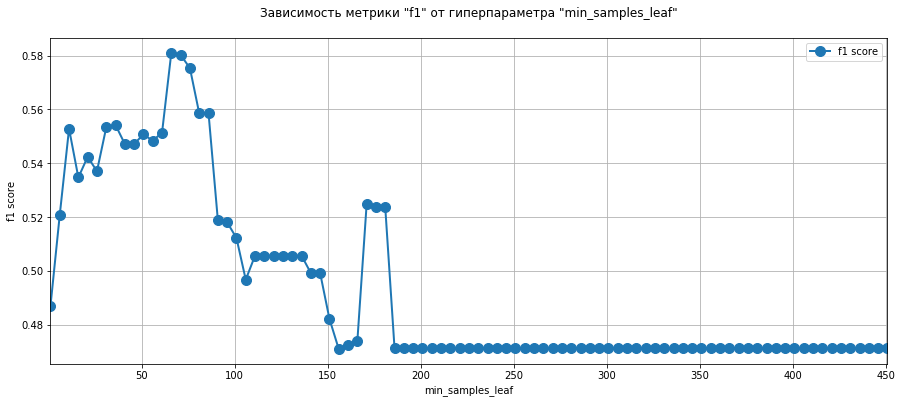

In [37]:
ax = hyper_tree.plot(
    y='f1', 
    marker='o', linewidth=2, markersize=10,
    title = 'Зависимость метрики "f1" от гиперпараметра "min_samples_leaf"\n',
    grid = True, label='f1 score', figsize=(15, 6))
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('f1 score')
plt.show()

#13. Есть максимум f1 меры около 66, получим его количественное значение.

In [38]:
hyper_tree.sort_values(by='f1', ascending=False).head(1)

,max_depth,f1,precision,recall,accuracy
66,12,0.581121,0.691228,0.501272,0.858


#14. По сравнению с моделью, у который гиперпараметры были по-умолчанию, удалось увеличить precision, однако recall остался приблизительно такимже около 50%. Т.е. модель стала более разборчива в определении класса (0 или 1), но определяет правильно только половину 1 (положительного класса). Обучим дерево с нашим лучшим гиперпараметром, построим roc-кривую и AUC.

In [39]:
model_decision_tree = DecisionTreeClassifier(random_state=100, min_samples_leaf=66)
model_decision_tree.fit(train_features, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=66, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [40]:
#функция для построения roc-кривой и AUC метрики
def ROC_curve_AUC(model, features, target):
    
    model.predict(features)
    score_one = model.predict_proba(features)[:, 1]
    auc_roc = round(roc_auc_score(target, score_one), 4)
    
    fpr, tpr, thresholds = roc_curve(target, score_one)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr)

    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая, AUC = '+str(auc_roc))
    plt.show()

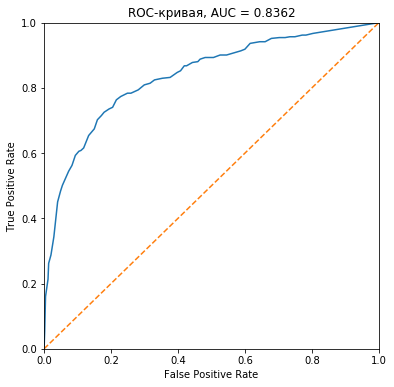

In [41]:
ROC_curve_AUC(model_decision_tree, valid_features, valid_target)

#### Вывод 2.3.1.  

Довести f1-метрику до 0.59 не удалось, максимум был получено 0.58 на валидационной выборке. Попробуем другие алгоритмы.

#### 2.3.2 Случайный лес

In [42]:
#возвращает датафрейм с гиперпараметрами критерий, глубиной дерева, кол-во деревьев  и основными метриками

def RandomForest_hyperP(train_features, train_target, valid_features, valid_target, #обучающая и валидационные выборки
                        max_depth_tree = 25,                                        #максимальная глубина дерева    
                        max_n_estimators = 201,                                     #максимальное число деревьев
                        delta_n_estimators = 15,                                    #дельта для перебора числа деревьев
                        criterions = ['gini', 'entropy'],                           #используемый критерий
                        class_w = None                                              #сбалансировать классы (default=None)
                       ):
    try:
        
        columns = ['criterion', 'max_depth', 'n_estimators', 'f1', 'precision', 'recall', 'accuracy']
        hyper_rf = pd.DataFrame(columns=columns)

        k = 0
        for name_crit in criterions:
            for depth in range(10, max_depth_tree, 1):
                for i in range(50, max_n_estimators, delta_n_estimators):
                    model_rf = RandomForestClassifier(random_state=100, class_weight = class_w,
                                                      criterion=name_crit, 
                                                      max_depth=depth, 
                                                      n_estimators = i,
                                                      n_jobs = -1
                                                     )
                    model_rf.fit(train_features, train_target)
                    hyper_rf.loc[k, 'criterion'] = name_crit
                    hyper_rf.loc[k, 'max_depth'] = depth
                    hyper_rf.loc[k, 'n_estimators'] = i
            
                    hyper_rf.loc[k, 'f1'] = f1_score(valid_target, model_rf.predict(valid_features))
    
                    hyper_rf.loc[k, 'precision'] = precision_score(valid_target, model_rf.predict(valid_features))
    
                    hyper_rf.loc[k, 'recall'] = recall_score(valid_target, model_rf.predict(valid_features))
    
                    hyper_rf.loc[k, 'accuracy'] = accuracy_score(valid_target, model_rf.predict(valid_features))
            
                    k+=1
        return hyper_rf
    except:
        print('ERROR in RandomForest_hyperP!!!!!')

In [43]:
%%time 
#8min 18s
#запустим функцию со стандартными пределами гиперпараметров для определения наилучших гиперпараметров
hyper_rf = RandomForest_hyperP(train_features, train_target, valid_features, valid_target)

CPU times: user 8min 1s, sys: 1.45 s, total: 8min 3s
Wall time: 8min 4s


In [44]:
#10 лучших комбинаций рассмотреных гиперпараметров
hyper_rf.sort_values(by='f1', ascending=False).head(10)

,criterion,max_depth,n_estimators,f1,precision,recall,accuracy
257,entropy,18,110,0.612954,0.808333,0.493639,0.8775
230,entropy,15,200,0.611465,0.817021,0.48855,0.878
255,entropy,18,80,0.608558,0.806723,0.48855,0.8765
256,entropy,18,95,0.608558,0.806723,0.48855,0.8765
300,entropy,22,95,0.607595,0.803347,0.48855,0.876
229,entropy,15,185,0.607313,0.809322,0.486005,0.8765
228,entropy,15,170,0.606349,0.805907,0.486005,0.876
297,entropy,22,50,0.606349,0.805907,0.486005,0.876
254,entropy,18,65,0.605388,0.802521,0.486005,0.8755
258,entropy,18,125,0.605388,0.802521,0.486005,0.8755


#15. Рассмотрим теперь лучший набор гиперпараметров. Обучим случайный лес с нними, построим roc-кривую и AUC меру.

In [45]:
hyper_rf.sort_values(by='f1', ascending=False).head(1)

,criterion,max_depth,n_estimators,f1,precision,recall,accuracy
257,entropy,18,110,0.612954,0.808333,0.493639,0.8775


In [46]:
model_rf = RandomForestClassifier(random_state=100, criterion='entropy', max_depth=18, n_estimators = 110, n_jobs = -1)
model_rf.fit(train_features, train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=18, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=-1, oob_score=False, random_state=100, verbose=0,
                       warm_start=False)

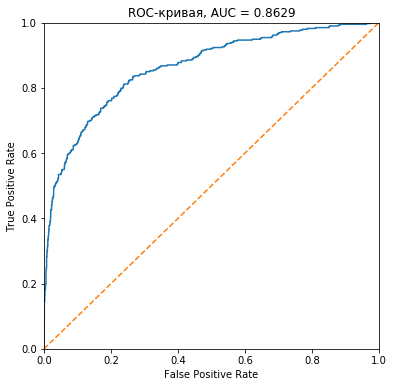

In [47]:
ROC_curve_AUC(model_rf, valid_features, valid_target)

#### Вывод 2.3.2.  

Нам удалось улучшить f1-метрику выше 0.59, максимум был получено 0.61 на валидационной выборке. При этом точность равна 0.808, а полнота 0.494. Так же по AUC данный алгоритм предпочтительней решающего дерева.

### 2.3.3 Логистическая регрессия

In [48]:
#возвращает датафрейм с гиперпараметром C и основными метриками

def LogisticRegression_hyperP(train_features, train_target, valid_features, valid_target, #обучающая и валидационные выборки
                              num_for_C = 25,       #кол-во разбиений обратного коэфф. регуляризации на отрезке от [0.01; 1]
                              class_w = None        #сбалансировать классы (default=None)
                             ):
    try:
        columns = ['c', 'f1', 'precision', 'recall', 'accuracy']
        hyper_logreg = pd.DataFrame(columns=columns)

        c_koeff = np.linspace(0.01, 1.0, num_for_C)

        k = 0
        for c in c_koeff:
            model_logreg = LogisticRegression(random_state=100, class_weight=class_w, C=c)
            model_logreg.fit(train_features, train_target)
    
            hyper_logreg.loc[k, 'c'] = c
    
            hyper_logreg.loc[k, 'f1'] = f1_score(valid_target, model_logreg.predict(valid_features))
    
            hyper_logreg.loc[k, 'precision'] = precision_score(valid_target, model_logreg.predict(valid_features))
    
            hyper_logreg.loc[k, 'recall'] = recall_score(valid_target, model_logreg.predict(valid_features))
    
            hyper_logreg.loc[k, 'accuracy'] = accuracy_score(valid_target, model_logreg.predict(valid_features))
    
            k+=1
    
        return hyper_logreg
    except:
        print('ERROR in LogisticRegression_hyperP!!!')

In [49]:
%%time
warnings.filterwarnings("ignore")
hyper_logreg = LogisticRegression_hyperP(train_features, train_target, valid_features, valid_target, num_for_C=30)

CPU times: user 6.33 s, sys: 4.49 s, total: 10.8 s
Wall time: 10.8 s


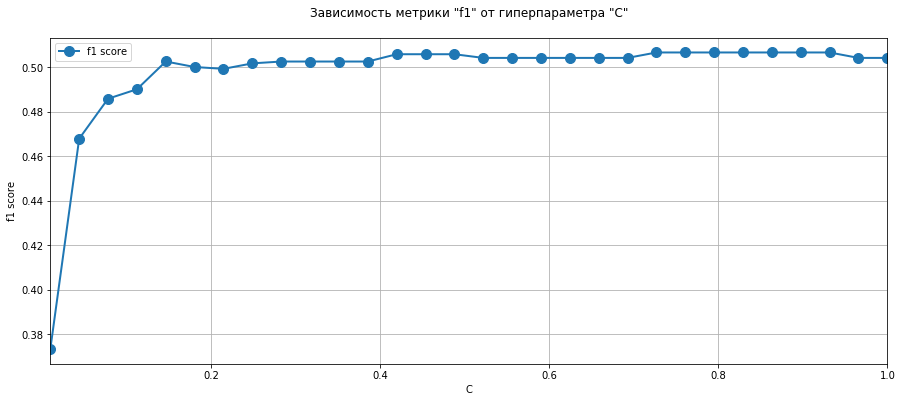

In [50]:
ax = hyper_logreg.plot(
    x='c',
    y='f1', 
    marker='o', linewidth=2, markersize=10,
    title = 'Зависимость метрики "f1" от гиперпараметра "C"\n',
    grid = True, label='f1 score', figsize=(15, 6))
ax.set_xlabel('C')
ax.set_ylabel('f1 score')
plt.show()

In [51]:
hyper_logreg.sort_values(by='f1', ascending=False).head(1)

,c,f1,precision,recall,accuracy
27,0.931724,0.506536,0.707763,0.394402,0.849


In [52]:
#Обучим модель с лучшим гиперпараметром
model_logreg = LogisticRegression(random_state=100, C=0.931724)
model_logreg.fit(train_features, train_target)
metrics(model_logreg, valid_features, valid_target)

f1:  0.5065	precision:  0.7078	recall:  0.3944		аccuracy:  0.849


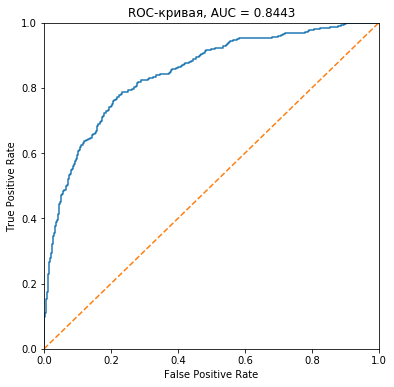

In [53]:
ROC_curve_AUC(model_logreg, valid_features, valid_target)

#### Вывод 2.3.3.  

Логистическая регрессия показала наихудший результат по f1-мере среди рассмотреных алгоритмов, хотя AUC у нее чуть лучше чем у решающего дерева.

## Вывод

Входе исследования на обучающей и валидационной выборках лучшей моделью по всем рассматриваемым метрикам оказался случайный лес со следующими гиперпараметрами:
**criterion**=*'entropy'*, **max_depth**=*18*, **n_estimators** = *110*

# 3. Борьба с дисбалансом

### 3.1 class_weight='balanced'  

Обучим снова наши модели, но с гиперпараметром *class_weight*=***'balanced'***

#### 3.1.1 Решающее дерево

In [54]:
%%time

hyper_tree_disbal_1 = DecisionTree_hyperP(train_features, train_target, valid_features, valid_target, 
                                          samples_leaf = 452, 
                                          delta_samples_leaf = 5,
                                          class_w='balanced'
                                         )

CPU times: user 3.12 s, sys: 8.02 ms, total: 3.13 s
Wall time: 3.13 s


In [55]:
print('Без учета дисбаланса')
display(hyper_tree.sort_values(by='f1', ascending=False).head(1))

print('C учетом дисбаланса (class_weight="balanced")')
display(hyper_tree_disbal_1.sort_values(by='f1', ascending=False).head(1))

Без учета дисбаланса


,max_depth,f1,precision,recall,accuracy
66,12,0.581121,0.691228,0.501272,0.858


C учетом дисбаланса (class_weight="balanced")


,max_depth,f1,precision,recall,accuracy
56,11,0.576714,0.503802,0.6743,0.8055


#### Вывод 3.1.1.  

Учет гиперпараметра class_weight='balanced' в совокупности ухудшил f1 меру, однако улучшил recall. 

#### 3.1.2 Случайный лес

In [56]:
%%time
#8min 44s
hyper_rf_disbal_1 = RandomForest_hyperP(train_features, train_target, valid_features, valid_target,
                                       class_w='balanced')

CPU times: user 8min 3s, sys: 1.73 s, total: 8min 4s
Wall time: 8min 5s


In [57]:
print('Без учета дисбаланса')
display(hyper_rf.sort_values(by='f1', ascending=False).head(1))

print('C учетом дисбаланса (class_weight="balanced")')
display(hyper_rf_disbal_1.sort_values(by='f1', ascending=False).head(1))

Без учета дисбаланса


,criterion,max_depth,n_estimators,f1,precision,recall,accuracy
257,entropy,18,110,0.612954,0.808333,0.493639,0.8775


C учетом дисбаланса (class_weight="balanced")


,criterion,max_depth,n_estimators,f1,precision,recall,accuracy
36,gini,13,95,0.638814,0.679083,0.603053,0.866


#### Вывод 3.1.2.  

Учет гиперпараметра class_weight='balanced' в совокупности улучшил f1 меру, однако precision уменьшился , а recall увеличился.

#### 3.1.3 логистическая регрессия

In [58]:
%%time

hyper_logreg_disbal_1 = LogisticRegression_hyperP(train_features, train_target, valid_features, valid_target, 
                                                  num_for_C=30,
                                                  class_w='balanced'
                                                 )

CPU times: user 6.41 s, sys: 4.51 s, total: 10.9 s
Wall time: 10.9 s


In [59]:
print('Без учета дисбаланса')
display(hyper_logreg.sort_values(by='f1', ascending=False).head(1))

print('C учетом дисбаланса')
display(hyper_logreg_disbal_1.sort_values(by='f1', ascending=False).head(1))

Без учета дисбаланса


,c,f1,precision,recall,accuracy
27,0.931724,0.506536,0.707763,0.394402,0.849


C учетом дисбаланса


,c,f1,precision,recall,accuracy
29,1,0.578846,0.465224,0.765903,0.781


#### Вывод 3.1.3.  

Учет гиперпараметра class_weight='balanced' в логистической регрессии улудшил f1 меру, через увеличеный recall. Однако f1 меньше требуемой.

### 3.2 upsampling

In [60]:
def upsample(features, target, repeat):
    try:
        features_0 = features[target == 0]
        features_1 = features[target == 1]
        target_0 = target[target == 0]
        target_1 = target[target == 1]

        features_up = pd.concat([features_0] + [features_1] * repeat)
        target_up = pd.concat([target_0] + [target_1] * repeat)
    
        features_up, target_up = shuffle(features_up, target_up, random_state=100)
    
        return features_up, target_up
    
    except:
        print('ERROR in upsample!!!')

In [61]:
#test
print(len(train_features))
features_up, target_up = upsample(train_features, train_target, 1)

target_up.value_counts()

6000


0    4784
1    1216
Name: exited, dtype: int64

#15. Будем варьировать ***repeat*** в функции upsample от 2 до 4. *repeat=4* - это когда обоих классов примерно одинаково. Создадим список

In [62]:
repeats = [2, 3, 4]

#### 3.2.1 Решающее дерево

In [63]:
%%time

print('Без учета дисбаланса')
display(hyper_tree.sort_values(by='f1', ascending=False).head(1))

for rep in repeats:
    
    features_up, target_up = upsample(train_features, train_target, rep)
    
    hyper_tree_disbal_2 = DecisionTree_hyperP(features_up, target_up, valid_features, valid_target, 
                                          samples_leaf = 452, 
                                          delta_samples_leaf = 5
                                         )
    
    print('C учетом дисбаланса (upsample with repeat={:})'.format(rep))
    display(hyper_tree_disbal_2.sort_values(by='f1', ascending=False).head(1))


Без учета дисбаланса


,max_depth,f1,precision,recall,accuracy
66,12,0.581121,0.691228,0.501272,0.858


C учетом дисбаланса (upsample with repeat=2)


,max_depth,f1,precision,recall,accuracy
81,11,0.608142,0.608142,0.608142,0.846


C учетом дисбаланса (upsample with repeat=3)


,max_depth,f1,precision,recall,accuracy
56,11,0.590414,0.51619,0.689567,0.812


C учетом дисбаланса (upsample with repeat=4)


,max_depth,f1,precision,recall,accuracy
66,11,0.576577,0.475248,0.732824,0.7885


CPU times: user 11.3 s, sys: 19.8 ms, total: 11.3 s
Wall time: 11.3 s


#### Вывод 3.2.1.  

С увеличением числа элементов положительного класса в upsampling, растет полнота(recall), при этом точность (precision) падает. В ходе расчета оптимальным оказалось использование удвоеного положительного класса (repeat = 2), т.к. он обеспечивает наибольшую f1-меру ~60.81% (precision=60.81%, recall=60.81%).

#### 3.2.2 Случайный лес

In [64]:
%%time

#расчет около 30 минут
print('Без учета дисбаланса')
display(hyper_rf.sort_values(by='f1', ascending=False).head(1))

for rep in repeats:
    
    features_up, target_up = upsample(train_features, train_target, rep)
    
    hyper_rf_disbal_2 = RandomForest_hyperP(features_up, target_up, valid_features, valid_target)
    
    print('C учетом дисбаланса (upsample with repeat={:})'.format(rep))
    display(hyper_rf_disbal_2.sort_values(by='f1', ascending=False).head(1))


Без учета дисбаланса


,criterion,max_depth,n_estimators,f1,precision,recall,accuracy
257,entropy,18,110,0.612954,0.808333,0.493639,0.8775


C учетом дисбаланса (upsample with repeat=2)


,criterion,max_depth,n_estimators,f1,precision,recall,accuracy
304,entropy,22,155,0.632332,0.722222,0.562341,0.8715


C учетом дисбаланса (upsample with repeat=3)


,criterion,max_depth,n_estimators,f1,precision,recall,accuracy
69,gini,16,95,0.643243,0.685879,0.605598,0.868


C учетом дисбаланса (upsample with repeat=4)


,criterion,max_depth,n_estimators,f1,precision,recall,accuracy
100,gini,19,65,0.641407,0.684971,0.603053,0.8675


CPU times: user 31min 19s, sys: 4.93 s, total: 31min 24s
Wall time: 31min 32s


#### Вывод 3.2.2.  

С увеличением числа элементов положительного класса в upsampling, растет полнота(recall), при этом точность (precision) падает, хотя не так сильно как у одного решающего дерева. В ходе расчета оптимальным оказалось использование утроеного положительного класса (repeat = 3), т.к. он обеспечивает наибольшую f1-меру ~64.32% (precision=68.58%, recall=60.06%) при гиперпараметрах:
**criterion**=*'gini'*, **max_depth**=*16*, **n_estimators** = *95*

#### 3.2.3 Логистическая регрессия

In [65]:
%%time

print('Без учета дисбаланса')
display(hyper_logreg.sort_values(by='f1', ascending=False).head(1))

for rep in repeats:
    
    features_up, target_up = upsample(train_features, train_target, rep)
    
    hyper_logreg_disbal_2 = LogisticRegression_hyperP(features_up, target_up, valid_features, valid_target, 
                                                  num_for_C=30
                                                 )
    
    print('C учетом дисбаланса (upsample with repeat={:})'.format(rep))
    display(hyper_logreg_disbal_2.sort_values(by='f1', ascending=False).head(1))


Без учета дисбаланса


,c,f1,precision,recall,accuracy
27,0.931724,0.506536,0.707763,0.394402,0.849


C учетом дисбаланса (upsample with repeat=2)


,c,f1,precision,recall,accuracy
4,0.146552,0.589128,0.585427,0.592875,0.8375


C учетом дисбаланса (upsample with repeat=3)


,c,f1,precision,recall,accuracy
1,0.0441379,0.58811,0.504554,0.704835,0.806


C учетом дисбаланса (upsample with repeat=4)


,c,f1,precision,recall,accuracy
1,0.0441379,0.576015,0.457958,0.776081,0.7755


CPU times: user 18.2 s, sys: 12.7 s, total: 30.9 s
Wall time: 30.9 s


#### Вывод 3.2.3.  

С увеличением числа элементов положительного класса, растет полнота(recall), при этом точность (precision) падает значительно. f1-мера более 0.59 достичь не удалось

### 3.3 downsampling

In [66]:
def downsample(features, target, fraction):
    features_0 = features[target == 0]
    features_1 = features[target == 1]
    target_0 = target[target == 0]
    target_1 = target[target == 1]

    features_down = pd.concat([features_0.sample(frac=fraction, random_state=100)] + [features_1])
    
    target_down = pd.concat([target_0.sample(frac=fraction, random_state=100)] + [target_1])
    
    features_down, target_down = shuffle(features_down, target_down, random_state=100)
    
    return features_down, target_down

In [67]:
#test 
print(len(train_features))
features_down, target_down = downsample(train_features, train_target, 1.0)

target_down.value_counts()

6000


0    4784
1    1216
Name: exited, dtype: int64

In [68]:
fractions = [0.25, 0.5, 0.75]

#### 3.3.1 Решающее дерево

In [69]:
%%time

print('Без учета дисбаланса')
display(hyper_tree.sort_values(by='f1', ascending=False).head(1))

for frac in fractions:
    
    features_down, target_down = downsample(train_features, train_target, frac)
    
    hyper_tree_disbal_3 = DecisionTree_hyperP(features_down, target_down, valid_features, valid_target, 
                                          samples_leaf = 452, 
                                          delta_samples_leaf = 5
                                         )
    
    print('C учетом дисбаланса (downsample with fraction={:})'.format(frac))
    display(hyper_tree_disbal_3.sort_values(by='f1', ascending=False).head(1))


Без учета дисбаланса


,max_depth,f1,precision,recall,accuracy
66,12,0.581121,0.691228,0.501272,0.858


C учетом дисбаланса (downsample with fraction=0.25)


,max_depth,f1,precision,recall,accuracy
51,8,0.573304,0.502879,0.666667,0.805


C учетом дисбаланса (downsample with fraction=0.5)


,max_depth,f1,precision,recall,accuracy
46,10,0.598269,0.581731,0.615776,0.8375


C учетом дисбаланса (downsample with fraction=0.75)


,max_depth,f1,precision,recall,accuracy
56,10,0.600273,0.647059,0.559796,0.8535


CPU times: user 7.08 s, sys: 19.9 ms, total: 7.1 s
Wall time: 7.11 s


#### Вывод 3.3.1.  

C уменьшением объектов нулевого класса растет recall, но сильно падает precision. Для решаюшего дерева на используемых данных наиболее предпочтительным оказался downsampling с fraction=0.75: получили f1 = 60.02% (precision=64.70%, recall=55.97%)

#### 3.3.2 Случайный лес

In [70]:
%%time
#17min 55s

print('Без учета дисбаланса')
display(hyper_rf.sort_values(by='f1', ascending=False).head(1))

for frac in fractions:
    
    features_down, target_down = downsample(train_features, train_target, frac)
    
    hyper_rf_disbal_3 = RandomForest_hyperP(features_down, target_down, valid_features, valid_target)
    
    print('C учетом дисбаланса (downsample with fraction={:})'.format(frac))
    display(hyper_rf_disbal_3.sort_values(by='f1', ascending=False).head(1))

Без учета дисбаланса


,criterion,max_depth,n_estimators,f1,precision,recall,accuracy
257,entropy,18,110,0.612954,0.808333,0.493639,0.8775


C учетом дисбаланса (downsample with fraction=0.25)


,criterion,max_depth,n_estimators,f1,precision,recall,accuracy
203,entropy,13,125,0.609562,0.500818,0.778626,0.804


C учетом дисбаланса (downsample with fraction=0.5)


,criterion,max_depth,n_estimators,f1,precision,recall,accuracy
247,entropy,17,125,0.633952,0.66205,0.608142,0.862


C учетом дисбаланса (downsample with fraction=0.75)


,criterion,max_depth,n_estimators,f1,precision,recall,accuracy
72,gini,16,140,0.622419,0.740351,0.536896,0.872


CPU times: user 17min 58s, sys: 3.39 s, total: 18min 1s
Wall time: 18min 5s


#### Вывод 3.3.2.  

C уменьшением объектов нулевого класса растет recall, но сильно падает precision, так что меньше становится f1-мера. Для случайного леса на используемых данных наиболее предпочтительным оказался downsampling с fraction=0.5: получили f1 = 63.39% (precision=66.21%, recall=60.81%) 

#### 3.3.3 Логистическая регрессия

In [71]:
%%time

print('Без учета дисбаланса')
display(hyper_logreg.sort_values(by='f1', ascending=False).head(1))

for frac in fractions:
    
    features_down, target_down = downsample(train_features, train_target, frac)
    
    hyper_logreg_disbal_3 = LogisticRegression_hyperP(features_down, target_down, valid_features, valid_target, 
                                                      num_for_C=30
                                                     )
    
    print('C учетом дисбаланса (downsample with fraction={:})'.format(frac))
    display(hyper_logreg_disbal_3.sort_values(by='f1', ascending=False).head(1))


Без учета дисбаланса


,c,f1,precision,recall,accuracy
27,0.931724,0.506536,0.707763,0.394402,0.849


C учетом дисбаланса (downsample with fraction=0.25)


,c,f1,precision,recall,accuracy
8,0.283103,0.576015,0.457958,0.776081,0.7755


C учетом дисбаланса (downsample with fraction=0.5)


,c,f1,precision,recall,accuracy
5,0.18069,0.595691,0.593434,0.597964,0.8405


C учетом дисбаланса (downsample with fraction=0.75)


,c,f1,precision,recall,accuracy
29,1,0.56094,0.663194,0.486005,0.8505


CPU times: user 14.1 s, sys: 11.8 s, total: 25.9 s
Wall time: 25.9 s


#### Вывод 3.3.3.  

C уменьшением объектов нулевого класса растет recall, но сильно падает precision. Для логистической регресии на используемых данных наиболее предпочтительным оказался downsampling с fraction=0.5: получили f1 = 59.57% (precision=59.34%, recall=59.79%) 

## Вывод  

Все рассмотренные методы борьбы с дисбалансом классов увеливают значение f1-меры за счет увеличения recall, при этом начинает падать precision. На представленной обучающей и валидационной выборках лучшим в борьбе с дисбалансом классов оказался **upsampling** с repeat=3 для случайного леся c гиперпараметрами:
**criterion**=*'gini'*, **max_depth**=*16*, **n_estimators** = *95*

# 4. Тестирование модели

#16. Чтобы построить более точный прогноз заново обучим модель, с лучшими гиперпараметрами, совместно на данных из обучающей и валидационной выборках.

In [72]:
#лучшие гиперпараметры: criterion='gini', max_depth=16, n_estimators = 95
model_final = RandomForestClassifier(random_state = 100, 
                                     criterion = 'gini', 
                                     max_depth = 16,
                                     n_estimators = 95
                                    )

In [73]:
#для борьбы с дисбалансом произведем upsampling с repeat=3
features_up, target_up = upsample(train_valid_features, train_valid_target, 3)

In [74]:
model_final.fit(features_up, target_up)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=95,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [75]:
#получим основные метрики
metrics(model_final, test_features, test_target)

f1:  0.6022	precision:  0.6412	recall:  0.5678		аccuracy:  0.8395


#17. Для проверки адекватности модели (на сколько она лучше случайной модели) построим ROC-кривую и посчитаем AUC

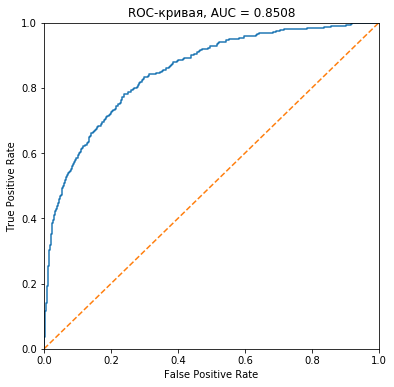

In [76]:
ROC_curve_AUC(model_final, test_features, test_target)

### Вывод  

**f1-мера** на тестовой выборке >= 0.59. На тестовой выборке AUC > 0.5 - значит модель адекватна (лучше случайной). Самая лучшая модель из рассмотреных позволила достигнуть цели исследования. 

# Вывод  

В ходе выполнения работы в наборе данных были обработаны пропуски и проведна подготовка признаков: категориальные признаки были преобразованы с помощью прямого и порядкового кодирования, а численные признаки были масштабированы. Первоначальный датафрейм был разбит на тренировочную, валидационную и тестовую выборки, по которым были обучены модели на основе трех алгоритмов обучения: решающее дерево, случайный лес и логистическая регрессия. Проварьировав гиперпараметры у данных алгоритмов, была найдена лучшая модель без учета дисбаланса(случайный лес). После чего был учтен дисбаланс и заново найдена лучшая модель, которая позволяет достичь на тестовой выборке F1-меры не менее 0.59(случайный лес). Данная модель также была проверена на адекватность, путем сравнения со случайной моделью, посредством построения ROC-кривой и расчета AUC меры.